General info
---
This is the coding part for the UCL 22/23 CASA module Urban Simulation (CASA0002)  
Assignment requirements avaliable [here](https://github.com/Murphy829/US22-23/blob/245e01187643b5a70bb2f5e724a45691aa0c1c03/Assessment%26MarkingScheme/AssessUrbanSim2023.pdf)  
Marking scheme avaliable [here](https://github.com/Murphy829/US22-23/blob/245e01187643b5a70bb2f5e724a45691aa0c1c03/Assessment%26MarkingScheme/UrbanSim_Marking_Scheme.pdf)  
Code is hosted [here](https://github.com/Murphy829/US22-23.git)  
Data is available [here](https://github.com/Murphy829/US22-23/tree/245e01187643b5a70bb2f5e724a45691aa0c1c03/Data)<br/> * *Please note: the datasets (including london underground graph and london_flows.csv) were preprocessed and outputed by Mateo Neira in module's Practiacal 10. The description and processing of the raw data can be found on Moodle-Week-10.*

# 0. Requirements for execution analysis

In [28]:
import sys
print(sys.version)

3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]


3.10.5 | packaged by conda-forge | (main, Jun 14 2022, 07:04:59) [GCC 10.3.0]

In [76]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import networkx as nx
from operator import itemgetter
import urllib.request
import io

import folium
import math
import scipy.stats
from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

In [77]:
# Read london underground graph data
url = "https://raw.githubusercontent.com/Murphy829/US22-23/main/Data/london.graph"
response = urllib.request.urlopen(url)
content = response.read().decode('utf-8')
file = io.StringIO(content)

G = nx.read_graphml(file)

In [78]:
# Take a look at our data
print(nx.info(G))

Graph with 401 nodes and 467 edges


In [1]:
import pandas as pd

In [2]:
london_flow = pd.read_csv('https://raw.githubusercontent.com/Murphy829/US22-23/main/Data/london_flows.csv')
london_flow.head()

,station_origin,station_destination,flows,population,jobs,distance
0,Abbey Road,Bank and Monument,0,599,78549,8131.525097
1,Abbey Road,Beckton,1,599,442,8510.121774
2,Abbey Road,Blackwall,3,599,665,3775.448872
3,Abbey Road,Canary Wharf,1,599,58772,5086.514220
4,Abbey Road,Canning Town,37,599,15428,2228.923167


In [3]:
import math

# prepropess data
def data_preprocess(df):
    '''
    data preprocess
    '''
    df = df[df['population'] != 0]
    df = df[df['jobs'] != 0]
    df = df[df['distance'] != 0]
    df = df.reset_index()

    df['log_pop'] = df['population']
    df['log_jobs'] = df['jobs']
    df['log_dis'] = df['distance']

    df['log_pop'] = df['log_pop'].apply(lambda x: math.log(x))
    df['log_jobs'] = df['log_jobs'].apply(lambda x: math.log(x))
    df['log_dis'] = df['log_dis'].apply(lambda x: math.log(x))
    return df

In [4]:
london_flow = data_preprocess(london_flow)
london_flow.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


# 🛡️Part 2: Spatial Interaction models

# **III. Models and calibration**

## III.1. Spatial interaction models

- unconstrained model
- production constrained model
- attraction constrained model
- production-attraction constrained

## III.2. Calibration of model

In [23]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

### unconstrained model

#### inverse power

In [91]:
f_un=london_flow.copy()

In [19]:
#create the formula for inverse power
formula_unconstrain_inv_power = 'flows ~ log_pop + log_jobs + log_dis'  #dis
#run the regression
uncosim_inv_power = smf.glm(formula = formula_unconstrain_inv_power, 
                    data=f_un, 
                    family=sm.families.Poisson()).fit()

In [20]:
print('inverse power')
print(uncosim_inv_power.summary())

inverse power
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2785e+06
Date:                Sun, 30 Apr 2023   Deviance:                   2.3848e+06
Time:                        04:56:52   Pearson chi2:                 4.76e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -3.7475      0.014   -27

In [21]:
K = uncosim_inv_power.params[0]
alpha = uncosim_inv_power.params[1]
gamma = uncosim_inv_power.params[2]
beta = -uncosim_inv_power.params[3]
print('inverse power')
print(f'K = {K}')
print(f'alpha = {alpha}')
print(f'gamma = {gamma}')
print(f'beta = {beta}')

inverse power
K = -3.747520395557363
alpha = 0.7324738922938139
gamma = 0.7607620351856279
beta = 0.6228020552901641


In [26]:
#first assign the parameter values from the model to the appropriate variables
K = uncosim_inv_power.params[0]
alpha = uncosim_inv_power.params[1]
gamma = uncosim_inv_power.params[2]
beta = -uncosim_inv_power.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
est = np.exp(K 
            + alpha*f_un["log_pop"] 
            + gamma*f_un["log_jobs"] 
            - beta*f_un["log_dis"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim_inv_power.get_prediction()
predictions_summary_frame = predictions.summary_frame()
f_un["est_inv_power"] = predictions_summary_frame["mean"]

In [27]:
f_un.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,est_inv_power
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,49.617996
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,0.937195
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,2.121375
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,53.297014
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,32.208586


In [29]:
R2 = CalcRSqaured(f_un["flows"], f_un["est_inv_power"])
RMSE = CalcRMSE(f_un["flows"], f_un["est_inv_power"])
print('unconstrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

unconstrained model, inverse power
R2=0.32, RMSE=108.33


#### negative exponential

In [95]:
#create the formula
#negative distance
formula_unconstrain_nega_dis = 'flows ~ log_pop + log_jobs + distance'  #dis
#run the regression
uncosim_nega_dis = smf.glm(formula = formula_unconstrain_nega_dis, 
                    data=f_un, 
                    family=sm.families.Poisson()).fit()

In [96]:
print('negative distance')
print(uncosim_nega_dis.summary())

negative distance
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61409
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.2445e+06
Date:                Sun, 30 Apr 2023   Deviance:                   2.3168e+06
Time:                        21:37:10   Pearson chi2:                 4.41e+06
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -7.9332      0.010  

In [98]:
K = uncosim_nega_dis.params[0]
alpha = uncosim_nega_dis.params[1]
gamma = uncosim_nega_dis.params[2]
beta = -uncosim_nega_dis.params[3]
print('Negative Exponential')
print(f'K = {K}')
print(f'alpha = {alpha}')
print(f'gamma = {gamma}')
print(f'beta = {beta}')

Negative Exponential
K = -7.933159072735435
alpha = 0.7027647840654084
gamma = 0.7363952004252391
beta = 9.036708790741632e-05


In [99]:
K = uncosim_nega_dis.params[0]
alpha = uncosim_nega_dis.params[1]
gamma = uncosim_nega_dis.params[2]
beta = -uncosim_nega_dis.params[3]

#now plug everything back into the Equation 6 model ... 
#be careful with the negative signing of the parameter beta
est = np.exp(K 
                                       + alpha*f_un["log_pop"] 
                                       + gamma*f_un["log_jobs"] 
                                       - beta*f_un["distance"])

#or we can just extract the results from the actual poisson regression and apply them to the data
predictions = uncosim_nega_dis.get_prediction()
predictions_summary_frame = predictions.summary_frame()
f_un["est_nega_dis"] = predictions_summary_frame["mean"]

In [101]:
R2 = CalcRSqaured(f_un["flows"], f_un["est_nega_dis"])
RMSE = CalcRMSE(f_un["flows"], f_un["est_nega_dis"])
print('unconstrained model, Negative Exponential')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

unconstrained model, Negative Exponential
R2=0.36, RMSE=105.72


### production constrained model

#### inverse power

In [40]:
f_p=london_flow.copy()

In [41]:
f_p['log_jobs'] = f_p['jobs']
f_p['log_dis'] = f_p['distance']

f_p['log_jobs'] = f_p['log_jobs'].apply(lambda x: math.log(x))
f_p['log_dis'] = f_p['log_dis'].apply(lambda x: math.log(x))

In [42]:
f_p.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [34]:
formula_inv_power = 'flows ~ station_origin + log_jobs + log_dis -1' 
ori_cosim_inv_power = smf.glm(formula = formula_inv_power, data=f_p, family=sm.families.Poisson()).fit()
print(ori_cosim_inv_power.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sun, 30 Apr 2023   Deviance:                   1.8615e+06
Time:                        05:07:50   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [41]:
print('production, beta inv power %.2f' % -ori_cosim_inv_power.params[-1])

production, beta inv power 0.88


In [37]:
predictions =ori_cosim_inv_power.get_prediction(f_p[["station_origin", "log_jobs","log_dis"]])
predictions_summary_framep = predictions.summary_frame()
f_p["est_inv_power"] = round(predictions_summary_framep["mean"],0)

inverse power


In [39]:
f_p.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,est_inv_power
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,55.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,3.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,66.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,49.0


In [40]:
R2 = CalcRSqaured(f_p["flows"], f_p["est_inv_power"])
RMSE = CalcRMSE(f_p["flows"], f_p["est_inv_power"])
print('production constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

origin constrained model, inverse power
R2=0.39, RMSE=102.89


#### negative exponential

In [43]:
formula_nega_dis = 'flows ~ station_origin + log_jobs + distance -1' 
ori_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=f_p, family=sm.families.Poisson()).fit()
#print(ori_cosim_nega_dis.summary())

In [46]:
print('production, nega beta %.2e' % -ori_cosim_nega_dis.params[-1])
print('production, nega gamma %.2e' % -ori_cosim_nega_dis.params[-2])

production, nega beta 1.53e-04
production, nega gamma -7.55e-01


production, nega beta 1.53e-04
production, nega gamma -7.55e-01

In [109]:
print('negative distance')
# print(uncosim_nega_dis.summary())
predictions =ori_cosim_nega_dis.get_prediction(f_p[["station_origin", "log_jobs","distance"]])
predictions_summary_framep = predictions.summary_frame()
f_p["est_nega_dis"] = round(predictions_summary_framep["mean"],0)

negative distance


In [110]:
R2 = CalcRSqaured(f_p["flows"], f_p["est_nega_dis"])
RMSE = CalcRMSE(f_p["flows"], f_p["est_nega_dis"])
print('origin constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

origin constrained model, negative distance
R2=0.47, RMSE=96.26


### attraction constrained model

#### inverse power

In [36]:
f_a=london_flow.copy()

In [37]:
f_a['log_pop'] = f_a['population']
f_a['log_dis'] = f_a['distance']

f_a['log_pop'] = f_a['log_pop'].apply(lambda x: math.log(x))
f_a['log_dis'] = f_a['log_dis'].apply(lambda x: math.log(x))

In [44]:
formula_inv_power = 'flows ~ log_pop + station_destination + log_dis -1' 
attraction_cosim_inv_power = smf.glm(formula = formula_inv_power, data=f_a, family=sm.families.Poisson()).fit()
print(attraction_cosim_inv_power.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.1646e+06
Date:                Sun, 30 Apr 2023   Deviance:                   2.1570e+06
Time:                        05:14:49   Pearson chi2:                 3.65e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                       coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [46]:
print('attraction,beta inv power %.2f' % -attraction_cosim_inv_power.params[-1])

attraction,beta inv power 0.64


In [47]:
predictions =attraction_cosim_inv_power.get_prediction(f_a[["log_pop", "station_destination","log_dis"]])
predictions_summary_framep = predictions.summary_frame()
f_a["est_inv_power"] = round(predictions_summary_framep["mean"],0)

In [48]:
f_a.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,est_inv_power
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,53.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,3.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,70.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,33.0


In [49]:
R2 = CalcRSqaured(f_a["flows"], f_a["est_inv_power"])
RMSE = CalcRMSE(f_a["flows"],f_a["est_inv_power"])
print('production constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

production constrained model, inverse power
R2=0.35, RMSE=106.01


#### negative exponential

In [38]:
formula_nega_dis = 'flows ~ log_pop + station_destination + distance -1' 
dest_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=f_a, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

In [30]:
print('dest, beta nega dis %.2e' % -dest_cosim_nega_dis.params[-1])
print('dest, gamma nega dis %.2e' % -dest_cosim_nega_dis.params[-2])

NameError: name 'dest_cosim_nega_dis' is not defined

In [117]:
print('negative distance')
predictions =dest_cosim_nega_dis.get_prediction(f_a[["log_pop", "station_destination","distance"]])
predictions_summary_framep = predictions.summary_frame()
f_a["est_nega_dis"] = round(predictions_summary_framep["mean"],0)

negative distance


In [119]:
R2 = CalcRSqaured(f_a["flows"], f_a["est_nega_dis"])
RMSE = CalcRMSE(f_a["flows"], f_a["est_nega_dis"])
print('origin constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

origin constrained model, negative distance
R2=0.40, RMSE=102.17


### production-attraction constrained model

#### inverse power

In [14]:
f_pa=london_flow.copy()

In [121]:
f_pa['log_dis'] = f_pa['distance']
f_pa['log_dis'] = f_pa['log_dis'].apply(lambda x: math.log(x))

In [7]:
formula_inv_power = 'flows ~ station_origin + station_destination + log_dis -1' 


In [8]:
pa_cosim_inv_power = smf.glm(formula = formula_inv_power, data=f_pa, family=sm.families.Poisson()).fit()


In [ ]:
# print(pa_cosim_inv_power.summary())

In [9]:
print('production-attraction, beta inv power %.2f' % -pa_cosim_inv_power.params[-1])

production-attraction, beta inv power 0.91


In [10]:
f_pa["est_inv_power"] = np.round(pa_cosim_inv_power.mu,0)

In [11]:
R2 = CalcRSqaured(f_pa["flows"], f_pa["est_inv_power"])
RMSE = CalcRMSE(f_pa["flows"], f_pa["est_inv_power"])
print('production-attraction constrained model, inverse power')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

production-attraction constrained model, inverse power
R2=0.41, RMSE=101.33


#### negative exponential

In [17]:
formula_nega_dis = 'flows ~ station_origin + station_destination + distance -1' 
doubly_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=f_pa, family=sm.families.Poisson()).fit()
#print(prodsim.summary())

In [29]:
print('dest,beta nega %.2e' % -doubly_cosim_nega_dis.params[-1])
print('dest,beta gamma %.2e' % -doubly_cosim_nega_dis.params[-2])

dest,beta nega 1.54e-04
dest,beta gamma -3.49e+00


dest,beta nega 1.54e-04
dest,gamma nega -3.49e+00

In [21]:
f_pa["est_nega_dis"] = np.round(doubly_cosim_nega_dis.mu,0)

In [28]:
R2 = CalcRSqaured(f_pa["flows"], f_pa["est_nega_dis"])
RMSE = CalcRMSE(f_pa["flows"], f_pa["est_nega_dis"])
print('origin constrained model, negative distance')
print(f'R2={R2:0.2f}, RMSE={RMSE:0.2f}')

origin constrained model, negative distance
R2=0.50, RMSE=93.40


origin constrained model, negative distance
R2=0.50, RMSE=93.40

# **IV. Scenarios**

## IV.1. Scenario A: assume that Canary Wharf has a 50% decrease in jobs after Brexit

### Production-constrained Model----inverse power

In [171]:
#R²
import scipy.stats

def CalcRSqaured(observed, estimated):
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

#RMSE
from math import sqrt

def CalcRMSE(observed, estimated):
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [172]:
data_Abefore = london_flow.copy()
data_Abefore.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [173]:
# Original ODmatrix
ODmatrix_Abefore = pd.pivot_table(data_Abefore, values='flows', index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
ODmatrix_Abefore

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [174]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'flows ~ station_origin + log_jobs + log_dis -1'

#run a production constrained sim
prodSim = smf.glm(formula = formula, data=data_Abefore, family=sm.families.Poisson()).fit()

In [18]:
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Sun, 30 Apr 2023   Deviance:                   1.8615e+06
Time:                        19:08:53   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [175]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

print("alpha_i")
print(alpha_i)

print('\ngamma')
print(gamma)

print('\nbeta')
print(beta)

alpha_i
station_origin[Abbey Road]          3.250242
station_origin[Acton Central]       5.016902
station_origin[Acton Town]          4.562892
station_origin[Aldgate]             3.323767
station_origin[Aldgate East]        3.457664
                                      ...   
station_origin[Wood Street]         5.242024
station_origin[Woodford]            5.160643
station_origin[Woodgrange Park]     5.254667
station_origin[Woodside Park]       4.698635
station_origin[Woolwich Arsenal]    6.905590
Length: 398, dtype: float64

gamma
0.7686156200124424

beta
0.8781191183724336


gamma
0.7686156200124424

beta
0.8781191183724336

In [176]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(data_Abefore.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
data_Abefore = data_Abefore.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(data_Abefore.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
data_Abefore = data_Abefore.merge(D_j, on = "station_destination", how = "left" )

In [177]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
    
#then once you have done this you can join them back into the dataframes
data_Abefore = data_Abefore.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
data_Abefore.drop(columns = ["coef"], inplace = True)
#check this has worked
data_Abefore.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250242
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250242
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250242
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250242


In [178]:
data_Abefore.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250242
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250242
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250242
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250242


In [179]:
data_Abefore["prodsimest1"] = np.exp(data_Abefore["alpha_i"]+gamma*data_Abefore["log_jobs"] 
                                 - beta*data_Abefore["log_dis"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
data_Abefore.head(10)

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i,prodsimest1
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,3.250242,55.010681
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,3.250242,0.986106
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,3.250242,2.755640
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,3.250242,66.457296
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,3.250242,49.060970
5,5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,3.250242,2.639418
6,6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,599,845,3.250242,3.275120
7,7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,599,1748,3.250242,2.838948
8,8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,599,850,3.250242,2.056310
9,9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,599,611,3.250242,2.476929


In [180]:
data_Abefore["prodsimest1"] = round(data_Abefore["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
ODmatrix_Abefore2 = data_Abefore.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
ODmatrix_Abefore2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,599.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,1223.0
Acton Town,NaN,NaN,NaN,18.0,18.0,NaN,9.0,1.0,NaN,20.0,...,16.0,3.0,5.0,13.0,NaN,2.0,NaN,2.0,NaN,3749.0
Aldgate,NaN,NaN,2.0,NaN,47.0,NaN,NaN,0.0,NaN,21.0,...,4.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2882.0
Aldgate East,NaN,NaN,2.0,52.0,NaN,NaN,1.0,0.0,NaN,23.0,...,5.0,1.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,7.0,35.0,39.0,NaN,NaN,NaN,NaN,32.0,...,15.0,NaN,10.0,NaN,NaN,NaN,NaN,NaN,NaN,4866.0
Woodgrange Park,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,5.0,20.0,20.0,NaN,2.0,NaN,NaN,25.0,...,11.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,3092.0


ODmatrix_Abefore2 compare ODmatrix_Abefore, cloumn=all, the Origin Constrained working

In [181]:
print(CalcRSqaured(data_Abefore["flows"], data_Abefore["prodsimest1"]))
CalcRMSE(data_Abefore["flows"], data_Abefore["prodsimest1"])

0.3882763950178627


102.893

inverse power  
0.3882763950178627  
102.893

### Production-constrained Model----negative exponential

In [182]:
data_Abefore_e = london_flow.copy()
data_Abefore_e.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [183]:
# negative exponential decay
formula = 'flows ~ station_origin + log_jobs + distance-1'
prodSim = smf.glm(formula = formula, data=data_Abefore_e, family=sm.families.Poisson()).fit()

In [72]:
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -9.0994e+05
Date:                Sun, 30 Apr 2023   Deviance:                   1.6477e+06
Time:                        23:29:27   Pearson chi2:                 2.40e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

In [184]:
alpha_i = prodSim.params[0:398]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

print("alpha_i")
print(alpha_i)

print('\ngamma')
print(gamma)

print('\nbeta')
print(beta)

alpha_i
station_origin[Abbey Road]         -2.914322
station_origin[Acton Central]      -1.162092
station_origin[Acton Town]         -1.613081
station_origin[Aldgate]            -2.943047
station_origin[Aldgate East]       -2.854752
                                      ...   
station_origin[Wood Street]        -0.942621
station_origin[Woodford]           -0.633605
station_origin[Woodgrange Park]    -0.896422
station_origin[Woodside Park]      -1.149110
station_origin[Woolwich Arsenal]    0.518041
Length: 398, dtype: float64

gamma
0.7552215895692552

beta
0.0001531661934634721


In [185]:
O_i = pd.DataFrame(data_Abefore_e.groupby(["station_origin"])["flows"].agg(np.sum))
O_i.rename(columns={"flows":"O_i"}, inplace = True)
data_Abefore_e = data_Abefore_e.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(data_Abefore_e.groupby(["station_destination"])["flows"].agg(np.sum))
D_j.rename(columns={"flows":"D_j"}, inplace = True)
data_Abefore_e = data_Abefore_e.merge(D_j, on = "station_destination", how = "left" )

In [186]:
#We can do this by pulling out the parameter values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(station_origin)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
data_Abefore_e = data_Abefore_e.merge(coefs, left_on="station_origin", right_on="coef", how = "left")
data_Abefore_e.drop(columns = ["coef"], inplace = True)
#check this has worked
data_Abefore_e.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,-2.914322
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,-2.914322
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,-2.914322
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,-2.914322
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,-2.914322


In [187]:
data_Abefore_e["prodsimest1"] = np.exp(data_Abefore_e["alpha_i"]+gamma*data_Abefore_e["log_jobs"] 
                                 - beta*data_Abefore_e["distance"])
data_Abefore_e.head(10)

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i,prodsimest1
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,-2.914322,77.685360
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,-2.914322,1.465951
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,-2.914322,4.121373
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,-2.914322,99.484532
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,-2.914322,56.125688
5,5,Abbey Road,Crossharbour,1,599,1208,6686.475560,6.395262,7.096721,8.807842,599,1208,-2.914322,4.141812
6,6,Abbey Road,Custom House,0,599,845,3824.855630,6.395262,6.739337,8.249276,599,845,-2.914322,4.901455
7,7,Abbey Road,Cutty Sark,2,599,1748,8503.898909,6.395262,7.466228,9.048280,599,1748,-2.914322,4.144676
8,8,Abbey Road,Cyprus,7,599,850,6532.099618,6.395262,6.745236,8.784484,599,850,-2.914322,3.252193
9,9,Abbey Road,Devons Road,1,599,611,3958.324171,6.395262,6.415097,8.283576,599,611,-2.914322,3.759238


In [188]:
data_Abefore_e["prodsimest1"] = round(data_Abefore_e["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
ODmatrix_Abefore_e = data_Abefore_e.pivot_table(values ="prodsimest1", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
ODmatrix_Abefore_e

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,595.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3744.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2885.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3160.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4867.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3100.0


In [189]:
print(CalcRSqaured(data_Abefore_e["flows"], data_Abefore_e["prodsimest1"]))
CalcRMSE(data_Abefore_e["flows"], data_Abefore_e["prodsimest1"])

0.46806484435428813


96.263

negative exponential  
0.46806484435428813  
96.263  

inverse power  
0.3882763950178627  
102.893  

negative exponential R² better

### Canary Wharf 50% decrease in jobs

In [227]:
data_A = data_Abefore_e.copy()
data_A

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274
...,...,...,...,...,...,...,...,...,...,...
61408,61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144
61409,61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245
61410,61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905
61411,61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832


In [226]:

def new_job(row):
    if row["station_destination"] == "Canary Wharf":
        val = round(row["jobs"]*0.5,0)
    else:
        val = row["jobs"]
    return val
        
data_A["Dj1_destjobScenario"] = data_A.apply(new_job, axis =1)
data_A['log_new_jobs'] = data_A['Dj1_destjobScenario']
data_A['log_new_jobs'] = data_A['log_new_jobs'].apply(lambda x: math.log(x))
data_A

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,new_jobs,log_new_jobs
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,78549.0,11.271478
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,442.0,6.091310
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,665.0,6.499787
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,29386.0,10.288274
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,15428.0,9.643939
...,...,...,...,...,...,...,...,...,...,...,...,...
61408,61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,3342.0,8.114325
61409,61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,5487.0,8.610137
61410,61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,400.0,5.991465
61411,61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,893.0,6.794587


In [193]:
data_A["prodsimest2"] = np.exp(data_A["alpha_i"]+gamma*np.log(data_A["Dj1_destjobScenario"]) - beta*data_A["distance"])

data_A["prodsimest2"] = round(data_A["prodsimest2"],0)
#now we can convert the pivot table into a matrix
ODmatrix_Aafter = data_A.pivot_table(values ="prodsimest2", index="station_origin", columns = "station_destination",
                            aggfunc=np.sum, margins=True)
ODmatrix_Aafter

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.0,555.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3730.0
Aldgate,NaN,NaN,1.0,NaN,37.0,NaN,NaN,0.0,NaN,27.0,...,2.0,NaN,2.0,2.0,NaN,1.0,NaN,1.0,NaN,2854.0
Aldgate East,NaN,NaN,1.0,40.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3117.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,41.0,52.0,NaN,NaN,NaN,NaN,30.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4765.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3083.0


In [194]:
data_A

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i,prodsimest1,Dj1_destjobScenario,prodsimest2
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,-2.914322,78.0,78549.0,78.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,-2.914322,1.0,442.0,1.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,-2.914322,4.0,665.0,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,-2.914322,99.0,29386.0,59.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,-2.914322,56.0,15428.0,56.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,7892,3342,0.518041,99.0,3342.0,99.0
61409,61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,7892,5487,0.518041,295.0,5487.0,295.0
61410,61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,7892,400,0.518041,36.0,400.0,36.0
61411,61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,7892,893,0.518041,125.0,893.0,125.0


In [195]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = data_A["jobs"]**gamma
dist_beta = np.exp(data_A["distance"]*-beta)

#calcualte the first stage of the Ai values
data_A["Ai1"] = Dj2_gamma * dist_beta

#now do the sum over all js bit
A_i = pd.DataFrame(data_A.groupby(["station_origin"])["Ai1"].agg(np.sum))

#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)

#and write the A_i values back into the dataframe
data_A = data_A.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [196]:
data_A

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i,prodsimest1,Dj1_destjobScenario,prodsimest2,Ai1,A_i
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,-2.914322,78.0,78549.0,78.0,1432.231104,0.000091
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,-2.914322,1.0,442.0,1.0,27.026714,0.000091
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,-2.914322,4.0,665.0,4.0,75.982904,0.000091
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,-2.914322,99.0,29386.0,59.0,1834.127323,0.000091
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,-2.914322,56.0,15428.0,56.0,1034.750388,0.000091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,7892,3342,0.518041,99.0,3342.0,99.0,58.874685,0.000213
61409,61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,7892,5487,0.518041,295.0,5487.0,295.0,175.878367,0.000213
61410,61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,7892,400,0.518041,36.0,400.0,36.0,21.416897,0.000213
61411,61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,7892,893,0.518041,125.0,893.0,125.0,74.528041,0.000213


In [197]:
#to check everything works, recreate the original estimates
data_A["prodsimest3"] = data_A["A_i"]*data_A["O_i"]*Dj2_gamma*dist_beta
#round
data_A["prodsimest3"] = round(data_A["prodsimest3"])
#check
data_A[["prodsimest1", "prodsimest2","prodsimest3"]]

,prodsimest1,prodsimest2,prodsimest3
0,78.0,78.0,78.0
1,1.0,1.0,1.0
2,4.0,4.0,4.0
3,99.0,59.0,99.0
4,56.0,56.0,56.0
...,...,...,...
61408,99.0,99.0,99.0
61409,295.0,295.0,295.0
61410,36.0,36.0,36.0
61411,125.0,125.0,125.0


In [198]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = data_A["Dj1_destjobScenario"]**gamma

#calcualte the first stage of the Ai values
data_A["Ai1"] = Dj3_gamma * dist_beta

#now do the sum over all js bit
A_i = pd.DataFrame(data_A.groupby(["station_origin"])["Ai1"].agg(np.sum))

#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)

#and write the A_i values back into the dataframe
data_A = data_A.merge(A_i, left_on="station_origin", right_index=True, how="left")

In [199]:
data_A

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,O_i,D_j,alpha_i,prodsimest1,Dj1_destjobScenario,prodsimest2,Ai1,A_i,prodsimest3,A_i2
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,599,78549,-2.914322,78.0,78549.0,78.0,1432.231104,0.000091,78.0,0.000097
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,599,442,-2.914322,1.0,442.0,1.0,27.026714,0.000091,1.0,0.000097
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,599,665,-2.914322,4.0,665.0,4.0,75.982904,0.000091,4.0,0.000097
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,599,58772,-2.914322,99.0,29386.0,59.0,1086.638601,0.000091,99.0,0.000097
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,599,15428,-2.914322,56.0,15428.0,56.0,1034.750388,0.000091,56.0,0.000097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,7892,3342,0.518041,99.0,3342.0,99.0,58.874685,0.000213,99.0,0.000230
61409,61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,7892,5487,0.518041,295.0,5487.0,295.0,175.878367,0.000213,295.0,0.000230
61410,61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,7892,400,0.518041,36.0,400.0,36.0,21.416897,0.000213,36.0,0.000230
61411,61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,7892,893,0.518041,125.0,893.0,125.0,74.528041,0.000213,125.0,0.000230


In [200]:
#to check everything works, recreate the original estimates
data_A["prodsimest4"] = data_A["A_i2"]*data_A["O_i"]*Dj3_gamma*dist_beta
#round
data_A["prodsimest4"] = round(data_A["prodsimest4"])

In [201]:
data_A

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,...,D_j,alpha_i,prodsimest1,Dj1_destjobScenario,prodsimest2,Ai1,A_i,prodsimest3,A_i2,prodsimest4
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,...,78549,-2.914322,78.0,78549.0,78.0,1432.231104,0.000091,78.0,0.000097,83.0
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,...,442,-2.914322,1.0,442.0,1.0,27.026714,0.000091,1.0,0.000097,2.0
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,...,665,-2.914322,4.0,665.0,4.0,75.982904,0.000091,4.0,0.000097,4.0
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,...,58772,-2.914322,99.0,29386.0,59.0,1086.638601,0.000091,99.0,0.000097,63.0
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,...,15428,-2.914322,56.0,15428.0,56.0,1034.750388,0.000091,56.0,0.000097,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61408,61469,Woolwich Arsenal,Tower Gateway,127,7892,3342,13401.795549,8.973605,8.114325,9.503144,...,3342,0.518041,99.0,3342.0,99.0,58.874685,0.000213,99.0,0.000230,107.0
61409,61470,Woolwich Arsenal,West Ham,608,7892,5487,8701.454361,8.973605,8.610137,9.071245,...,5487,0.518041,295.0,5487.0,295.0,175.878367,0.000213,295.0,0.000230,320.0
61410,61471,Woolwich Arsenal,West India Quay,6,7892,400,9536.720451,8.973605,5.991465,9.162905,...,400,0.518041,36.0,400.0,36.0,21.416897,0.000213,36.0,0.000230,39.0
61411,61472,Woolwich Arsenal,West Silvertown,81,7892,893,5355.248554,8.973605,6.794587,8.585832,...,893,0.518041,125.0,893.0,125.0,74.528041,0.000213,125.0,0.000230,135.0


In [202]:
ODmatrix_Aafter2 = data_A.pivot_table(values ="prodsimest4", index="station_origin", columns = "station_destination",
                         aggfunc=np.sum, margins=True)
ODmatrix_Aafter2

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.0,597.0
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1226.0
Acton Town,NaN,NaN,NaN,13.0,13.0,NaN,14.0,0.0,NaN,16.0,...,13.0,3.0,2.0,20.0,NaN,0.0,NaN,1.0,NaN,3750.0
Aldgate,NaN,NaN,1.0,NaN,38.0,NaN,NaN,0.0,NaN,28.0,...,2.0,NaN,3.0,2.0,NaN,1.0,NaN,1.0,NaN,2886.0
Aldgate East,NaN,NaN,1.0,41.0,NaN,NaN,0.0,0.0,NaN,29.0,...,2.0,0.0,3.0,2.0,NaN,1.0,NaN,1.0,NaN,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,1.0,42.0,53.0,NaN,NaN,NaN,NaN,31.0,...,2.0,NaN,6.0,NaN,NaN,NaN,NaN,NaN,NaN,4860.0
Woodgrange Park,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,532.0
Woodside Park,NaN,NaN,2.0,19.0,19.0,NaN,0.0,NaN,NaN,32.0,...,3.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,3102.0


In [203]:
ODmatrix_Abefore

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,32.0,599
Acton Central,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,1224
Acton Town,NaN,NaN,NaN,3.0,17.0,NaN,35.0,0.0,NaN,11.0,...,77.0,3.0,6.0,9.0,NaN,0.0,NaN,0.0,NaN,3745
Aldgate,NaN,NaN,0.0,NaN,0.0,NaN,NaN,0.0,NaN,17.0,...,0.0,NaN,4.0,8.0,NaN,0.0,NaN,0.0,NaN,2886
Aldgate East,NaN,NaN,2.0,0.0,NaN,NaN,0.0,0.0,NaN,20.0,...,24.0,0.0,0.0,12.0,NaN,1.0,NaN,1.0,NaN,3172
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,NaN,NaN,2.0,5.0,47.0,NaN,NaN,NaN,NaN,22.0,...,2.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,4868
Woodgrange Park,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,530
Woodside Park,NaN,NaN,1.0,26.0,11.0,NaN,0.0,NaN,NaN,59.0,...,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,3093


In [204]:
CalcRSqaured(data_A["flows"],data_A["prodsimest1"])

0.46806484435428813

In [205]:
CalcRSqaured(data_A["flows"],data_A["prodsimest2"])

0.45199654379795606

In [206]:
CalcRSqaured(data_A["flows"],data_A["prodsimest3"])

0.46806484435428813

In [207]:
CalcRSqaured(data_A["flows"],data_A["prodsimest4"])

0.4516520758982265

In [208]:
A_result = data_A[['station_origin','station_destination','prodsimest4','flows']]
A_result['diff'] = A_result['prodsimest4'] - A_result['flows']
A_result

,station_origin,station_destination,prodsimest4,flows,diff
0,Abbey Road,Bank and Monument,83.0,0,83.0
1,Abbey Road,Beckton,2.0,1,1.0
2,Abbey Road,Blackwall,4.0,3,1.0
3,Abbey Road,Canary Wharf,63.0,1,62.0
4,Abbey Road,Canning Town,60.0,37,23.0
...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,107.0,127,-20.0
61409,Woolwich Arsenal,West Ham,320.0,608,-288.0
61410,Woolwich Arsenal,West India Quay,39.0,6,33.0
61411,Woolwich Arsenal,West Silvertown,135.0,81,54.0


In [209]:
A_result.sort_values('diff')

,station_origin,station_destination,prodsimest4,flows,diff
55890,Waterloo,Bank and Monument,3717.0,15946,-12229.0
55915,Waterloo,Canary Wharf,836.0,8085,-7249.0
32609,London Bridge,Canary Wharf,553.0,6165,-5612.0
50041,Stratford,Liverpool Street,2621.0,6946,-4325.0
54769,Victoria,Oxford Circus,1527.0,5181,-3654.0
...,...,...,...,...,...
32282,Liverpool Street,Bank and Monument,2392.0,812,1580.0
32709,London Bridge,Liverpool Street,1762.0,163,1599.0
49857,Stratford,Bank and Monument,2784.0,1138,1646.0
56116,Waterloo,Victoria,2051.0,285,1766.0


In [210]:
# A_result.to_csv('Output/scena_A_result.csv', index=False)

In [277]:
A_diff_o = pd.DataFrame(columns=['prodsimest4_sum','flow_sum'])
A_diff_o['prodsimest4_sum'] = pd.DataFrame(A_result.groupby(["station_origin"])["prodsimest4"].agg(np.sum))
A_diff_o['flow_sum'] = pd.DataFrame(A_result.groupby(["station_origin"])["flows"].agg(np.sum))
A_diff_o['change_ratio'] = (A_diff_o['prodsimest4_sum'] - A_diff_o['flow_sum']) 
A_diff_o = A_diff_o.sort_values('change_ratio')
A_diff_o

,prodsimest4_sum,flow_sum,change_ratio
station_origin,,,
Leicester Square,969.0,985,-16.0
Parsons Green,4345.0,4361,-16.0
Mile End,7129.0,7145,-16.0
Barbican,1224.0,1239,-15.0
Temple,335.0,349,-14.0
...,...,...,...
West Hampstead,10378.0,10371,7.0
Pinner,2883.0,2875,8.0
Highbury & Islington,23723.0,23714,9.0


In [278]:
A_diff = pd.DataFrame(columns=['prodsimest4_sum','flow_sum'])
A_diff['prodsimest4_sum'] = pd.DataFrame(A_result.groupby(["station_destination"])["prodsimest4"].agg(np.sum))
A_diff['flow_sum'] = pd.DataFrame(A_result.groupby(["station_destination"])["flows"].agg(np.sum))
A_diff['change_ratio'] = (A_diff['prodsimest4_sum'] - A_diff['flow_sum']) 
A_diff = A_diff.sort_values('change_ratio')
A_diff

,prodsimest4_sum,flow_sum,change_ratio
station_destination,,,
Canary Wharf,29489.0,58772,-29283.0
Bank and Monument,70019.0,78549,-8530.0
Hammersmith,13071.0,18250,-5179.0
Victoria,28939.0,33251,-4312.0
Oxford Circus,40062.0,44368,-4306.0
...,...,...,...
Embankment,13227.0,10220,3007.0
Highbury & Islington,29978.0,25385,4593.0
Canada Water,25343.0,20443,4900.0


In [313]:
A_diff_o = pd.DataFrame(columns=['prodsimest4_sum','flow_sum'])
A_diff_o['prodsimest4_sum'] = pd.DataFrame(A_result.groupby(["station_origin"])["prodsimest4"].agg(np.sum))
A_diff_o['flow_sum'] = pd.DataFrame(A_result.groupby(["station_origin"])["flows"].agg(np.sum))
A_diff_o['change_ratio'] = (A_diff_o['prodsimest4_sum'] - A_diff_o['flow_sum']) 
A_diff_o = A_diff_o.sort_values('change_ratio')
A_diff_o

,prodsimest4_sum,flow_sum,change_ratio
station_origin,,,
Leicester Square,969.0,985,-16.0
Parsons Green,4345.0,4361,-16.0
Mile End,7129.0,7145,-16.0
Barbican,1224.0,1239,-15.0
Temple,335.0,349,-14.0
...,...,...,...
West Hampstead,10378.0,10371,7.0
Pinner,2883.0,2875,8.0
Highbury & Islington,23723.0,23714,9.0


In [316]:
# A_diff_o.to_csv('Output/scena_A_diff_o_result.csv', index=True)

In [291]:
df_test

,station_destination,prodsimest4_sum,flow_sum,change_ratio
0,Abbey Road,411.0,345,66.0
1,Acton Central,359.0,750,-391.0
2,Acton Town,2172.0,2202,-30.0
3,Aldgate,8638.0,7782,856.0
4,Aldgate East,9612.0,7932,1680.0
...,...,...,...,...
393,Wood Street,397.0,404,-7.0
394,Woodford,673.0,706,-33.0
395,Woodgrange Park,160.0,242,-82.0
396,Woodside Park,427.0,745,-318.0


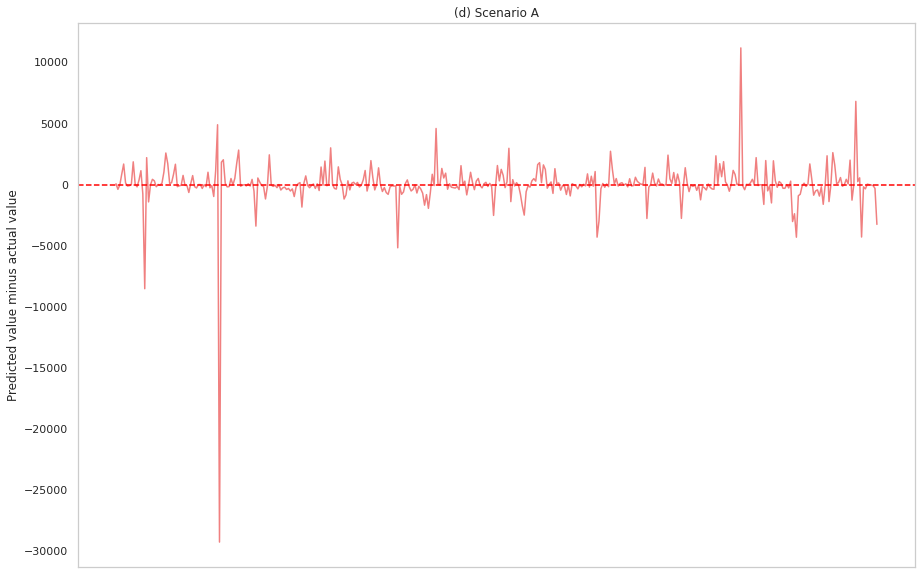

In [309]:
import matplotlib.pyplot as plt

df_test = A_diff.copy()
df_test = df_test.sort_values('station_destination')
df_test = df_test.reset_index(drop=False)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(df_test['station_destination'], df_test['change_ratio'], color='lightcoral')

# 隐藏x轴刻度
ax.xaxis.set_visible(False)

# 设置背景为纯白色，关掉网格
ax.set_facecolor('white')
ax.grid(False)

# 添加红色虚线
ax.axhline(y=0, color='red', linestyle='--')

ax.set_ylabel('Predicted value minus actual value')
ax.set_title('(d) Scenario A')

# plt.savefig('Output/Figure_scenario_Abydestination.png', dpi=300, bbox_inches='tight')

plt.show()


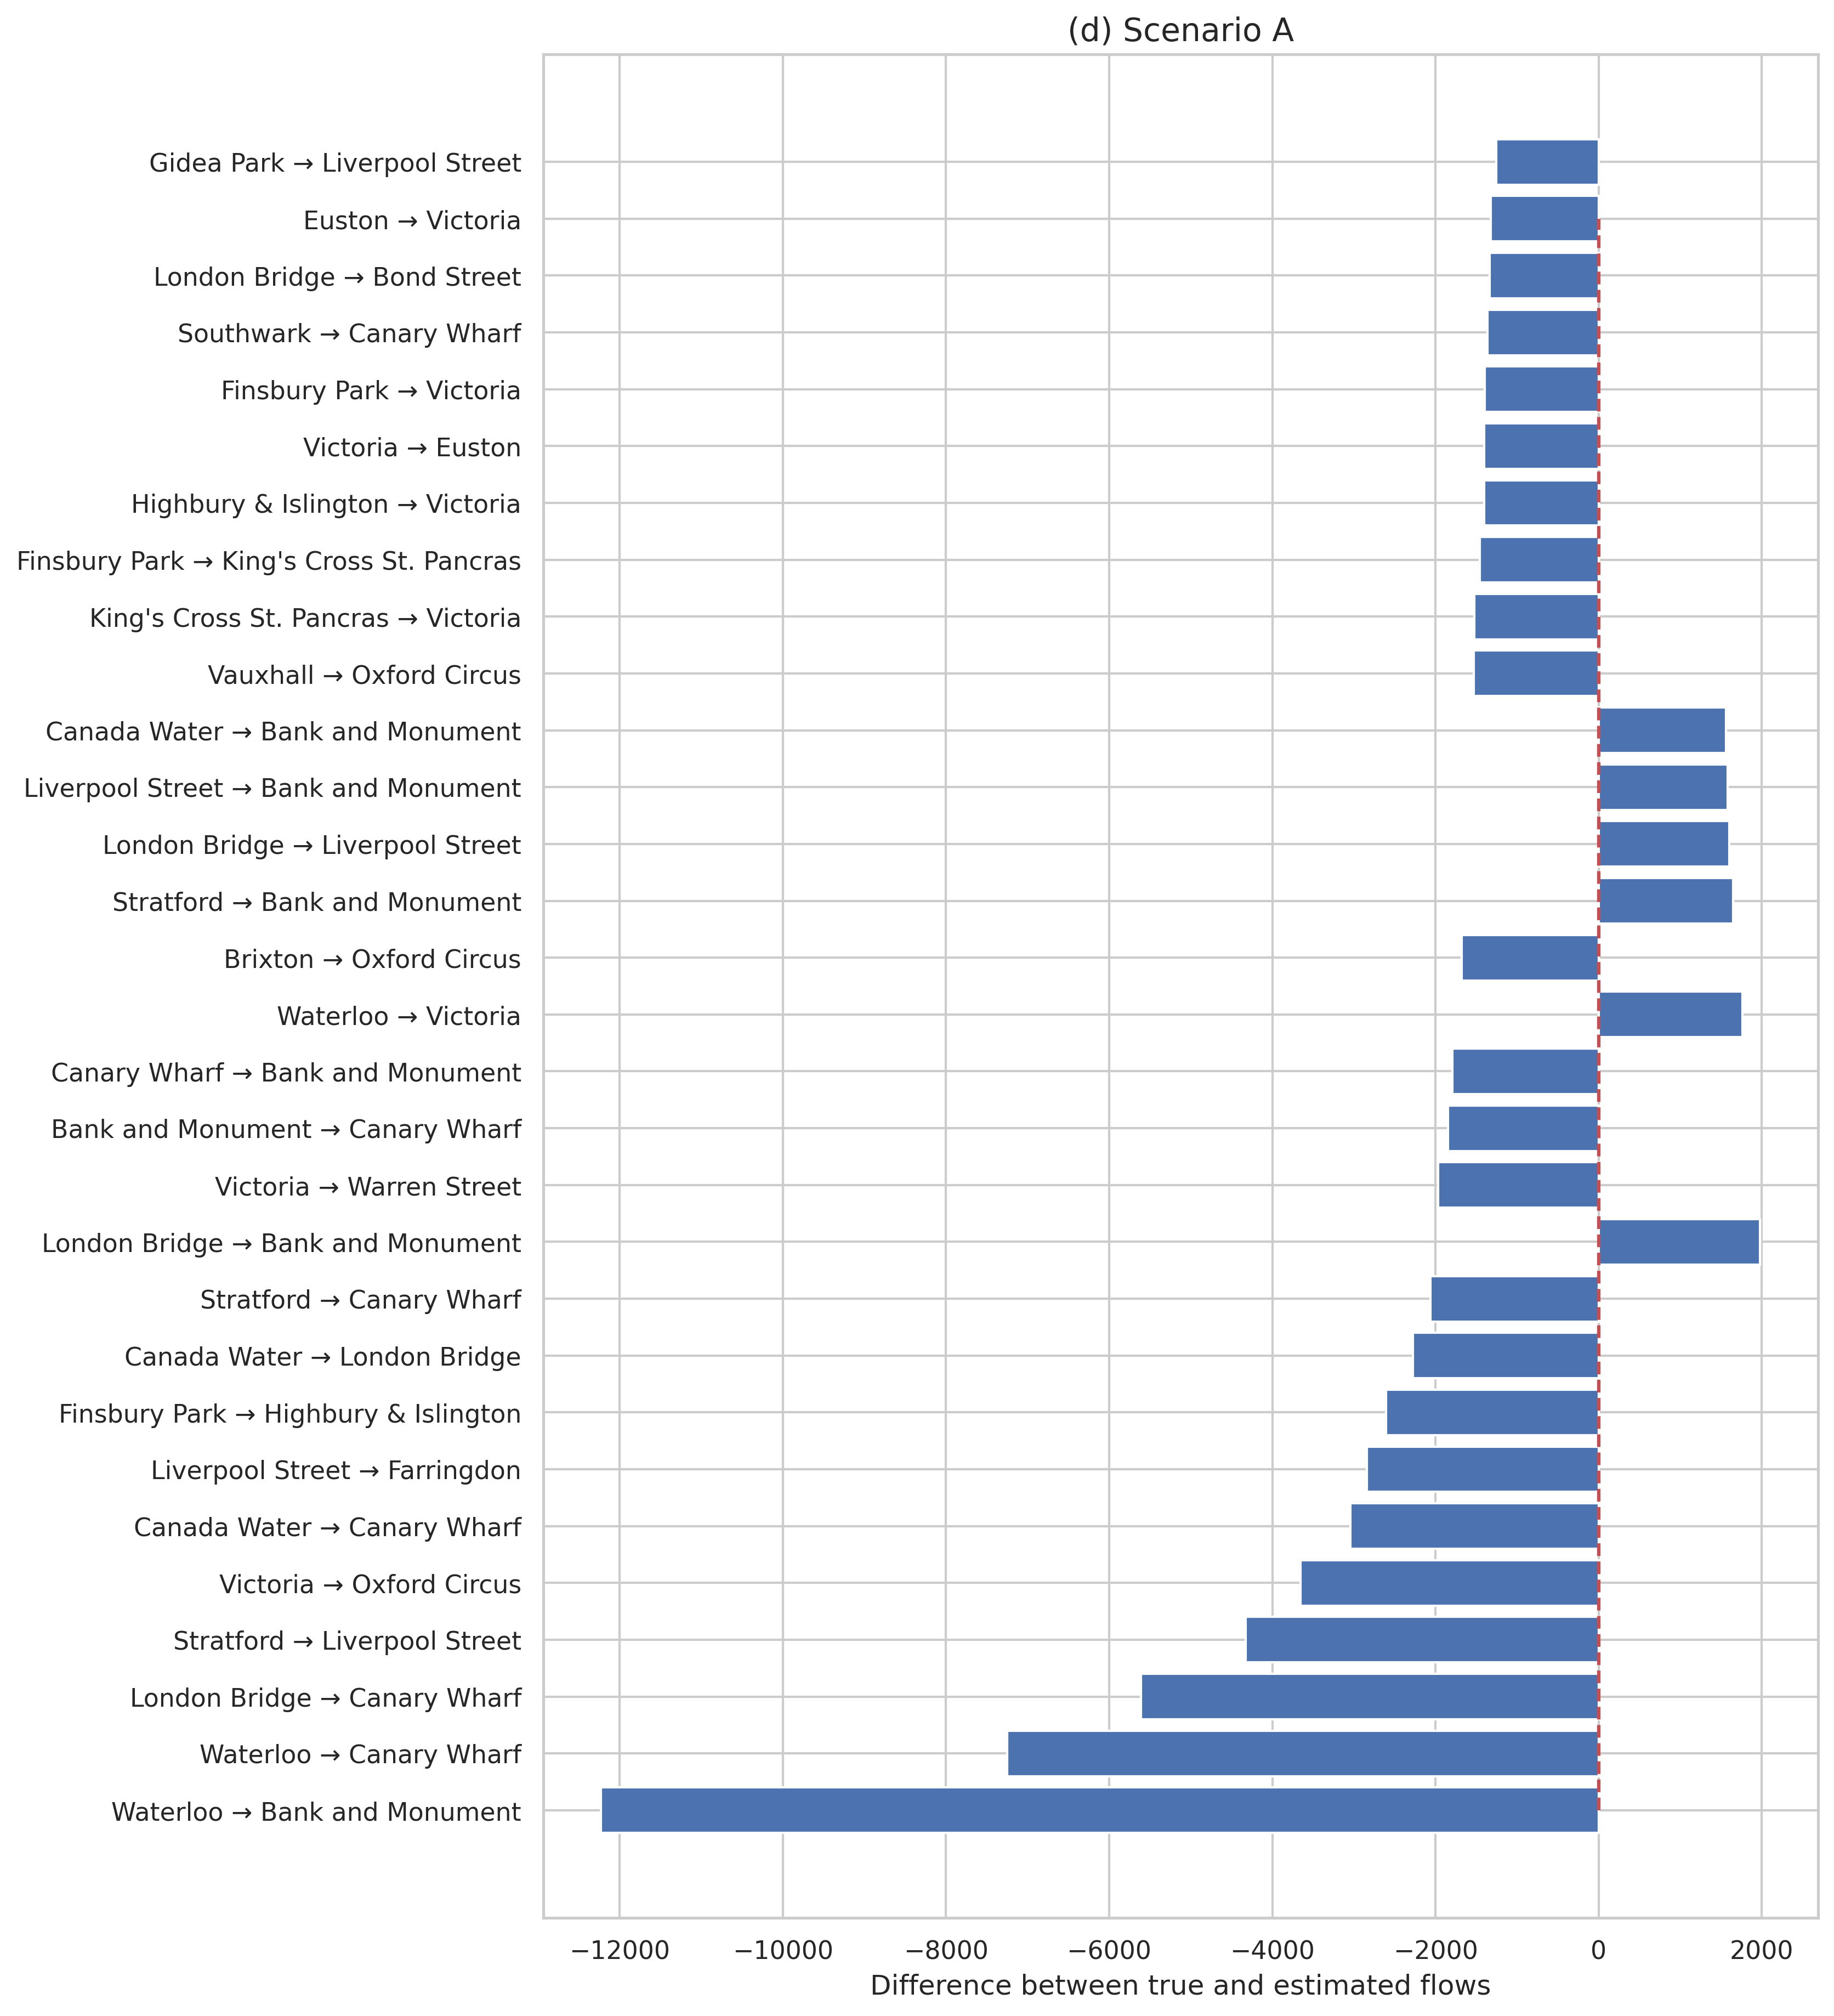

In [259]:
plt.figure(figsize=(10, 15), dpi=300)
sns.set_theme(style='whitegrid')

A_result['abs_diff'] = abs(A_result['diff'])
o_d_= []

A_result = A_result.sort_values('abs_diff',ascending=False).reset_index()
A_result = A_result.drop(columns='index')
for i in range(30):
    o_d_.append(A_result.iloc[i,0] + ' → ' + A_result.iloc[i,1])
plt.barh(o_d_, A_result.loc[:29,'diff'])
plt.vlines(0, 0, 28, colors = "r", linestyles = "dashed")
plt.title('(d) Scenario A',fontsize=14)

# 设置横坐标标签
plt.xlabel('Difference between true and estimated flows', fontsize=12)

# plt.savefig('Output/Figure_scenario_A.png', dpi=300, bbox_inches='tight')

plt.show()


In [260]:
# A_diff.to_csv('Output/scena_A_diff_result.csv', index=True)

In [ ]:
plt.figure(figsize=(10, 15), dpi=300)
sns.set_theme(style='whitegrid')

A_result['abs_diff'] = abs(A_result['diff'])
o_d_= []

A_result = A_result.sort_values('abs_diff',ascending=False).reset_index()
A_result = A_result.drop(columns='index')
for i in range(30):
    o_d_.append(A_result.iloc[i,0] + ' → ' + A_result.iloc[i,1])
plt.barh(o_d_, A_result.loc[:29,'diff'])
plt.vlines(0, 0, 28, colors = "r", linestyles = "dashed")
plt.title('(d) Scenario A',fontsize=14)

# 设置横坐标标签
plt.xlabel('Difference between true and estimated flows', fontsize=12)

# plt.savefig('Output/Figure_scenario_A.png', dpi=300, bbox_inches='tight')

plt.show()


In [213]:
G_plot = G.copy()
G_plot = G_plot.subgraph(A_diff.index)
for node in G_plot.nodes():
    G_plot.nodes[node]['coords'] = eval(G_plot.nodes[node]['coords'])
nx.set_node_attributes(G_plot, A_diff['change_ratio'], 'change_ratio')
nx.set_node_attributes(G_plot, A_diff['prodsimest4_sum'], 'prodsimest4_flows')
nx.set_node_attributes(G_plot, A_diff['flow_sum'], 'real_flows')

list(G_plot.nodes(data = True))[0]

("Earl's Court",
 {'coords': (525466.7699525921, 178494.18714144814),
  'change_ratio': 709.0,
  'prodsimest4_flows': 7322.0,
  'real_flows': 6613})

In [214]:
reduce_flow = A_diff[A_diff['change_ratio'] < 0]
increase_flow = A_diff[A_diff['change_ratio'] >= 0]
G_reduce = G_plot.subgraph(reduce_flow.index)
G_increase = G_plot.subgraph(increase_flow.index)
list(G_reduce.nodes(data = True))[0]

('Hammersmith',
 {'coords': (523377.08389789803, 178624.18457495343),
  'change_ratio': -5179.0,
  'prodsimest4_flows': 13071.0,
  'real_flows': 18250})

<Figure size 600x400 with 0 Axes>

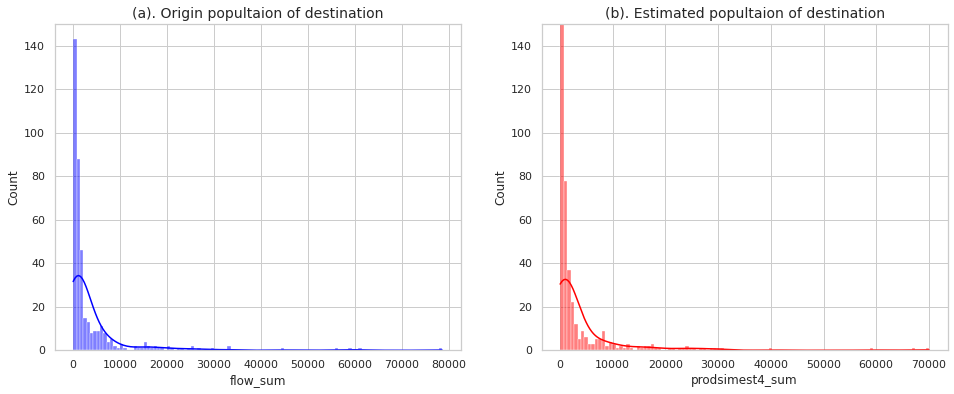

In [215]:
plt.figure(dpi=100)
fig, ax = plt.subplots(1,2,figsize=(16,6))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="whitegrid")

# ax[0].hist(scena_A_diff['flow_sum'])
sns.histplot(data=A_diff, x="flow_sum", color="blue", kde=True,ax=ax[0])
ax[0].set_title('(a). Origin popultaion of destination',fontsize=14)
ax[0].set_ylim(0,150)
sns.histplot(data=A_diff, x="prodsimest4_sum", color="red", kde=True,ax=ax[1])
ax[1].set_title('(b). Estimated popultaion of destination',fontsize=14)
ax[1].set_ylim(0,150)

plt.show()

<Figure size 600x400 with 0 Axes>

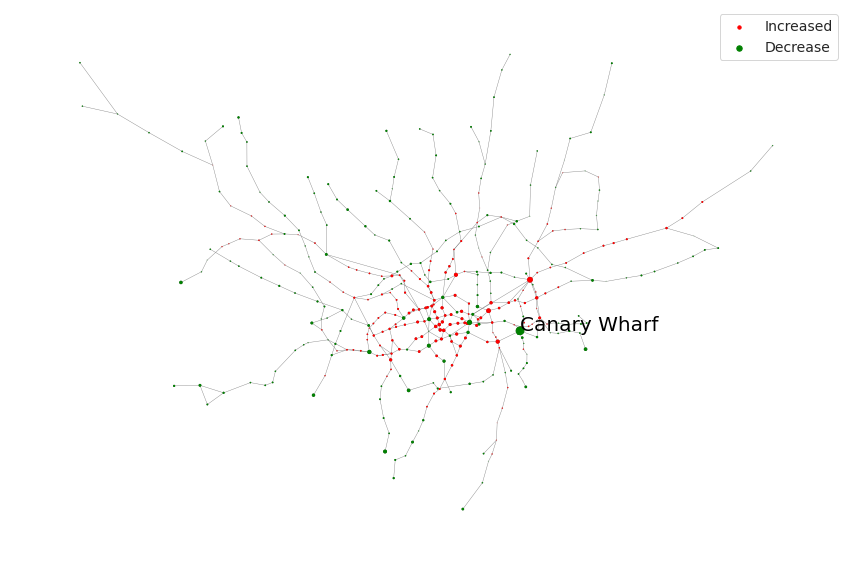

In [312]:
# Lets set colour and size of nodes according to betweenness values

ratio_values=[(abs(i[1]['change_ratio'])) for i in G_plot.nodes(data=True)]
ratio_size=[(abs(i[1]['change_ratio']))/500 for i in G_plot.nodes(data=True)]
ratio_size_increase=[(abs(i[1]['change_ratio']))/500 for i in G_increase.nodes(data=True)]
ratio_size_reduce=[(abs(i[1]['change_ratio']))/500 for i in G_reduce.nodes(data=True)]


# Plot graph

pos = nx.get_node_attributes(G_plot, 'coords')
plt.figure(dpi=100)
fig, ax = plt.subplots(figsize=(12,8))


nx.draw_networkx_edges(G_plot, pos,edge_color='gray', 
        width=0.4,ax=ax)

nod=nx.draw_networkx_nodes(G_plot,
        pos = pos,
        node_color= 'grey',
        node_size= ratio_size,
        ax=ax)

nx.draw_networkx_nodes(G_increase,
        pos = pos,
        node_color= 'red',
        label='Increased',
        node_size= ratio_size_increase,
        ax=ax)

nx.draw_networkx_nodes(G_reduce,
        pos = pos,
        node_color= 'green',
        label='Decrease',
        node_size= ratio_size_reduce,
        ax=ax)

ax.text(x=537586.6947649193,y=180311.85419390627,s='Canary Wharf',color='black',fontsize=20)
ax.axis("off")
# ax.set_title("(c) Scenario A:change of destination population",fontsize=22)
plt.legend(fontsize=14)
plt.tight_layout()

plt.savefig('Output/Figure_scenario_A_map.png', dpi=300, bbox_inches='tight')
plt.show()



## IV.2. Scenario B: assume that there is a significant increase in the cost of transport

choose doubly constrained model and negative exponential function

In [50]:
london_flow_doubly = london_flow.copy()
london_flow_doubly.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274


In [51]:
# import scipy.stats
# from math import sqrt
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [52]:
formula_nega_dis = 'flows ~ station_origin + station_destination + distance -1' 
doubly_cosim_nega_dis = smf.glm(formula = formula_nega_dis, data=london_flow_doubly, family=sm.families.Poisson()).fit()

In [53]:
print(doubly_cosim_nega_dis.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    60617
Model Family:                 Poisson   Df Model:                          795
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -8.5105e+05
Date:                Mon, 01 May 2023   Deviance:                   1.5299e+06
Time:                        02:04:29   Pearson chi2:                 2.02e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                         coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

In [54]:
alpha_val = doubly_cosim_nega_dis.params[0:398]
gamma_val = doubly_cosim_nega_dis.params[399:795]
beta_val = -doubly_cosim_nega_dis.params[-1]

print("alpha")
print(alpha_val)

print('\ngamma')
print(gamma_val)

print('\nbeta')
print(beta_val)

alpha
station_origin[Abbey Road]          1.354150
station_origin[Acton Central]       2.965314
station_origin[Acton Town]          2.780711
station_origin[Aldgate]             1.537233
station_origin[Aldgate East]        1.625544
                                      ...   
station_origin[Wood Street]         3.390992
station_origin[Woodford]            3.856952
station_origin[Woodgrange Park]     3.063112
station_origin[Woodside Park]       3.292851
station_origin[Woolwich Arsenal]    4.742926
Length: 398, dtype: float64

gamma
station_destination[T.Acton Town]          1.440836
station_destination[T.Aldgate]             2.222441
station_destination[T.Aldgate East]        2.153787
station_destination[T.All Saints]          0.163051
station_destination[T.Alperton]            0.799412
                                             ...   
station_destination[T.Wood Street]         0.213082
station_destination[T.Woodford]            0.556487
station_destination[T.Woodgrange Park]     0.401

In [55]:
coefs = pd.DataFrame(doubly_cosim_nega_dis.params)
coefs = coefs.reset_index()
# coefs.columns = ['coef','gamma_j']

In [56]:
alpha_i = coefs.iloc[0:398,:]
alpha_i.columns = ['origin','alpha_i']

to_repl = ['(station_origin)','\[','\]']
for x in to_repl:
    alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')

alpha_i

/tmp/ipykernel_80/807542931.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')
/tmp/ipykernel_80/807542931.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alpha_i['origin'] = alpha_i['origin'].str.replace(x,'')


,origin,alpha_i
0,Abbey Road,1.354150
1,Acton Central,2.965314
2,Acton Town,2.780711
3,Aldgate,1.537233
4,Aldgate East,1.625544
...,...,...
393,Wood Street,3.390992
394,Woodford,3.856952
395,Woodgrange Park,3.063112
396,Woodside Park,3.292851


In [57]:
gamma_j = coefs.iloc[399:-1,:]
gamma_j.columns = ['destination','gamma_j']

to_repl = ['(station_destination)','\[','\]']
for x in to_repl:
    gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')

for i in range(len(gamma_j)):
    gamma_j.iloc[i,0] = gamma_j.iloc[i,0].replace('T.','')

gamma_j

/tmp/ipykernel_80/4018159816.py:6: FutureWarning: The default value of regex will change from True to False in a future version.
  gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')
/tmp/ipykernel_80/4018159816.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gamma_j['destination'] = gamma_j['destination'].str.replace(x,'')


,destination,gamma_j
399,Acton Town,1.440836
400,Aldgate,2.222441
401,Aldgate East,2.153787
402,All Saints,0.163051
403,Alperton,0.799412
...,...,...
790,Wood Street,0.213082
791,Woodford,0.556487
792,Woodgrange Park,0.401733
793,Woodside Park,1.106866


In [58]:
beta = coefs.iloc[-1,:]
beta.columns = ['distance','beta']
minus_beta = beta.iloc[1] # with minus symbol

print('beta:',minus_beta)

beta: -0.0001543696921559367


beta: -0.0001543696921559367

In [15]:
import numpy as np

In [59]:
london_flow_doubly = london_flow_doubly.merge(alpha_i,left_on='station_origin',right_on='origin',how='left')
london_flow_doubly = london_flow_doubly.merge(gamma_j,left_on='station_destination',right_on='destination',how='left')
london_flow_doubly['est'] = np.exp(london_flow_doubly['alpha_i'] + 
                                    london_flow_doubly['gamma_j'] + 
                                    minus_beta*london_flow_doubly['distance'])

london_flow_doubly['est'] = round(london_flow_doubly["est"])

In [60]:
london_flow_doubly = london_flow_doubly.drop(columns=['destination','origin'],axis=1)

In [61]:
O_i = pd.DataFrame(london_flow_doubly.groupby(["station_origin"])["flows"].agg(np.sum))
O_i = O_i.reset_index()
O_i.rename(columns={"flows":"O_i"}, inplace = True)
london_flow_doubly = london_flow_doubly.merge(O_i, on = "station_origin", how = "left" )

D_j = pd.DataFrame(london_flow_doubly.groupby(["station_destination"])["flows"].agg(np.sum))
D_j = D_j.reset_index()
D_j.rename(columns={"flows":"D_j"}, inplace = True)
london_flow_doubly = london_flow_doubly.merge(D_j, on = "station_destination", how = "left" )

In [62]:
# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd

In [63]:
london_flow_doubly.head()

,index,station_origin,station_destination,flows,population,jobs,distance,log_pop,log_jobs,log_dis,alpha_i,gamma_j,est,O_i,D_j
0,0,Abbey Road,Bank and Monument,0,599,78549,8131.525097,6.395262,11.271478,9.003504,1.35415,4.242924,77.0,599,78549
1,1,Abbey Road,Beckton,1,599,442,8510.121774,6.395262,6.091310,9.049012,1.35415,0.944441,3.0,599,442
2,2,Abbey Road,Blackwall,3,599,665,3775.448872,6.395262,6.499787,8.236275,1.35415,0.527704,4.0,599,665
3,3,Abbey Road,Canary Wharf,1,599,58772,5086.514220,6.395262,10.981421,8.534348,1.35415,4.148524,112.0,599,58772
4,4,Abbey Road,Canning Town,37,599,15428,2228.923167,6.395262,9.643939,7.709274,1.35415,2.856294,48.0,599,15428


In [64]:
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',minus_beta,'exponential','Ai_new','Bj_new')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_1beta'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_new'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_new'] * 
                                   np.exp(london_flow_doubly['distance']*minus_beta))
# Check out the matrix
cdatasubmat3 = pd.pivot_table(cdatasub,values='SIM_est_1beta',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23


In [65]:
cdatasubmat3

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,31,603.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1221.0
Acton Town,0,0,0,11,10,0,17,0,0,12,...,40,4,2,19,0,0,0,1,0,3752.0
Aldgate,0,0,1,0,32,0,0,0,0,23,...,7,0,3,2,0,1,0,1,0,2883.0
Aldgate East,0,0,2,38,0,0,0,0,0,24,...,7,1,3,2,0,1,0,1,0,3167.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,2,38,44,0,0,0,0,25,...,7,0,7,0,0,0,0,0,0,4862.0
Woodgrange Park,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,2,17,15,0,0,0,0,25,...,10,0,4,0,0,0,0,0,0,3093.0


In [49]:
ODmatrix_Abefore

NameError: name 'ODmatrix_Abefore' is not defined

### Double beta

In [91]:
new_minus_beta = minus_beta * 2
new_minus_beta

-0.0003087393843118734

In [92]:
new_minus_beta = minus_beta * 2
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',new_minus_beta,'exponential','Ai_dou_beta','Bj_dou_beta')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_2beta'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_dou_beta'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_dou_beta'] * 
                                   np.exp(london_flow_doubly['distance']*new_minus_beta))
# Check out the matrix
cdatasubmat_dou_beta = pd.pivot_table(cdatasub,values='SIM_est_2beta',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48


In [93]:
cdatasubmat_dou_beta

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,22,602.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1220.0
Acton Town,0,0,0,4,3,0,13,0,0,5,...,28,1,0,32,0,0,0,0,0,3749.0
Aldgate,0,0,0,0,48,0,0,0,0,27,...,1,0,1,1,0,0,0,0,0,2881.0
Aldgate East,0,0,0,60,0,0,0,0,0,28,...,1,0,1,1,0,0,0,0,0,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,38,52,0,0,0,0,18,...,1,0,2,0,0,0,0,0,0,4861.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,526.0
Woodside Park,0,0,0,10,8,0,0,0,0,25,...,2,0,1,0,0,0,0,0,0,3089.0


In [ ]:
ODmatrix_Abefore

### triple beta

In [94]:
triple_minus_beta = minus_beta * 3
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',triple_minus_beta,'exponential','Ai_tri_beta','Bj_tri_beta')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_3beta'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_tri_beta'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_tri_beta'] * 
                                   np.exp(london_flow_doubly['distance']*triple_minus_beta))
# Check out the matrix
cdatasubmat_tri_beta = pd.pivot_table(cdatasub,values='SIM_est_3beta',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [95]:
cdatasubmat_tri_beta

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,15,599.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1223.0
Acton Town,0,0,0,1,1,0,5,0,0,2,...,9,0,0,40,0,0,0,0,0,3739.0
Aldgate,0,0,0,0,59,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,2875.0
Aldgate East,0,0,0,82,0,0,0,0,0,27,...,0,0,0,0,0,0,0,0,0,3163.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,36,58,0,0,0,0,13,...,0,0,0,0,0,0,0,0,0,4856.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,0,6,5,0,0,0,0,25,...,0,0,0,0,0,0,0,0,0,3088.0


In [ ]:
ODmatrix_Abefore

### Five times beta

In [96]:
five_minus_beta = minus_beta * 5
# Use the beta we got from the negative exponential model
# beta = -doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(london_flow_doubly,'station_origin','station_destination','O_i','D_j','distance',five_minus_beta,'exponential','Ai_five_beta','Bj_five_beta')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_5beta'] = np.round(london_flow_doubly['O_i'] * london_flow_doubly['Ai_five_beta'] * london_flow_doubly['D_j'] * london_flow_doubly['Bj_five_beta'] * 
                                   np.exp(london_flow_doubly['distance']*five_minus_beta))
# Check out the matrix
cdatasubmat_five_beta = pd.pivot_table(cdatasub,values='SIM_est_5beta',index ='station_origin',columns='station_destination',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [97]:
cdatasubmat_five_beta

station_destination,Abbey Road,Acton Central,Acton Town,Aldgate,Aldgate East,All Saints,Alperton,Amersham,Anerley,Angel,...,Wimbledon,Wimbledon Park,Wood Green,Wood Lane,Wood Street,Woodford,Woodgrange Park,Woodside Park,Woolwich Arsenal,All
station_origin,,,,,,,,,,,,,,,,,,,,,
Abbey Road,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,598.0
Acton Central,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1225.0
Acton Town,0,0,0,0,0,0,0,0,0,0,...,0,0,0,42,0,0,0,0,0,3743.0
Aldgate,0,0,0,0,60,0,0,0,0,18,...,0,0,0,0,0,0,0,0,0,2885.0
Aldgate East,0,0,0,114,0,0,0,0,0,19,...,0,0,0,0,0,0,0,0,0,3170.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Woodford,0,0,0,34,68,0,0,0,0,6,...,0,0,0,0,0,0,0,0,0,4866.0
Woodgrange Park,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,528.0
Woodside Park,0,0,0,3,1,0,0,0,0,26,...,0,0,0,0,0,0,0,0,0,3087.0


In [ ]:
ODmatrix_Abefore

In [98]:
# beta
cdatasub[['SIM_est_1beta','SIM_est_2beta','SIM_est_3beta','SIM_est_5beta','flows']]

,SIM_est_1beta,SIM_est_2beta,SIM_est_3beta,SIM_est_5beta,flows
0,77.0,52.0,41.0,32.0,0
1,3.0,2.0,1.0,0.0,1
2,4.0,3.0,3.0,3.0,3
3,112.0,113.0,109.0,101.0,1
4,48.0,63.0,73.0,94.0,37
...,...,...,...,...,...
61408,185.0,120.0,83.0,44.0,127
61409,176.0,164.0,122.0,56.0,608
61410,27.0,21.0,17.0,12.0,6
61411,132.0,193.0,265.0,426.0,81


In [100]:
# calculate diff
scena_B_result = cdatasub[['station_origin','station_destination','SIM_est_1beta','SIM_est_2beta','SIM_est_3beta','SIM_est_5beta','flows']]

In [101]:
scena_B_result

,station_origin,station_destination,SIM_est_1beta,SIM_est_2beta,SIM_est_3beta,SIM_est_5beta,flows
0,Abbey Road,Bank and Monument,77.0,52.0,41.0,32.0,0
1,Abbey Road,Beckton,3.0,2.0,1.0,0.0,1
2,Abbey Road,Blackwall,4.0,3.0,3.0,3.0,3
3,Abbey Road,Canary Wharf,112.0,113.0,109.0,101.0,1
4,Abbey Road,Canning Town,48.0,63.0,73.0,94.0,37
...,...,...,...,...,...,...,...
61408,Woolwich Arsenal,Tower Gateway,185.0,120.0,83.0,44.0,127
61409,Woolwich Arsenal,West Ham,176.0,164.0,122.0,56.0,608
61410,Woolwich Arsenal,West India Quay,27.0,21.0,17.0,12.0,6
61411,Woolwich Arsenal,West Silvertown,132.0,193.0,265.0,426.0,81


In [102]:
scena_B_result['2beta_diff'] = scena_B_result['SIM_est_2beta'] - scena_B_result['flows'] 
scena_B_result['3beta_diff'] = scena_B_result['SIM_est_3beta'] - scena_B_result['flows'] 
scena_B_result['5beta_diff'] = scena_B_result['SIM_est_5beta'] - scena_B_result['flows'] 
scena_B_result.head()

,station_origin,station_destination,SIM_est_1beta,SIM_est_2beta,SIM_est_3beta,SIM_est_5beta,flows,2beta_diff,3beta_diff,5beta_diff
0,Abbey Road,Bank and Monument,77.0,52.0,41.0,32.0,0,52.0,41.0,32.0
1,Abbey Road,Beckton,3.0,2.0,1.0,0.0,1,1.0,0.0,-1.0
2,Abbey Road,Blackwall,4.0,3.0,3.0,3.0,3,0.0,0.0,0.0
3,Abbey Road,Canary Wharf,112.0,113.0,109.0,101.0,1,112.0,108.0,100.0
4,Abbey Road,Canning Town,48.0,63.0,73.0,94.0,37,26.0,36.0,57.0


In [103]:
# scena_B_result.to_csv('Output/scena_B_result.csv', index=False)

In [271]:
scena_B_result_2 = pd.DataFrame(columns=['SIM_est_2beta_sum','flow_sum'])
scena_B_result_2['SIM_est_2beta_sum'] = pd.DataFrame(scena_B_result.groupby(["station_destination"])["SIM_est_2beta"].agg(np.sum))
scena_B_result_2['flow_sum'] = pd.DataFrame(scena_B_result.groupby(["station_destination"])["flows"].agg(np.sum))
scena_B_result_2['change_ratio'] = (scena_B_result_2['SIM_est_2beta_sum'] - scena_B_result_2['flow_sum']) 
scena_B_result_2 = scena_B_result_2.sort_values('change_ratio')
scena_B_result_2
scena_B_result_2.to_csv('Output/scena_B_result_2.csv', index=True)

In [295]:
scena_B_result_2

,SIM_est_2beta_sum,flow_sum,change_ratio
station_destination,,,
Tooting Bec,1211.0,1239,-28.0
Wembley Park,5732.0,5759,-27.0
Blackhorse Road,2929.0,2955,-26.0
Upton Park,1620.0,1642,-22.0
Wembley Central,1305.0,1327,-22.0
...,...,...,...
Angel,8111.0,8103,8.0
Paddington,20201.0,20193,8.0
Westminster,15474.0,15466,8.0


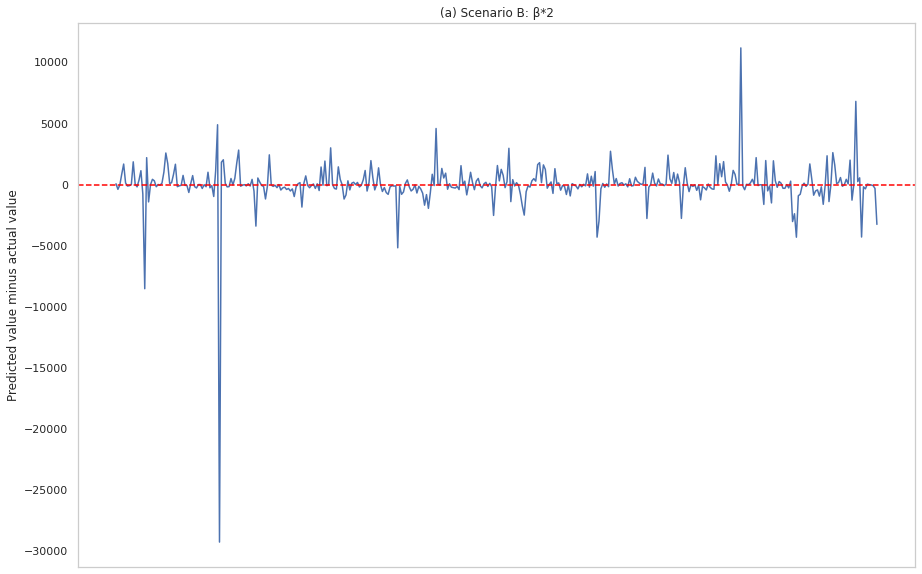

In [299]:
import matplotlib.pyplot as plt

dfdouble=scena_B_result_2.copy()

dfdouble = A_diff.copy()
dfdouble = dfdouble.sort_values('station_destination')
dfdouble = dfdouble.reset_index(drop=False)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(dfdouble['station_destination'], dfdouble['change_ratio'])

# 隐藏x轴刻度
ax.xaxis.set_visible(False)

# 设置背景为纯白色，关掉网格
ax.set_facecolor('white')
ax.grid(False)

# 添加红色虚线
ax.axhline(y=0, color='red', linestyle='--')

ax.set_ylabel('Predicted value minus actual value')
ax.set_title('(a) Scenario B: β*2')

plt.savefig('Output/Figure_scenario_Bdoublebydestination.png', dpi=300, bbox_inches='tight')

plt.show()

In [272]:
scena_B_result_3 = pd.DataFrame(columns=['SIM_est_3beta_sum','flow_sum'])
scena_B_result_3['SIM_est_3beta_sum'] = pd.DataFrame(scena_B_result.groupby(["station_destination"])["SIM_est_3beta"].agg(np.sum))
scena_B_result_3['flow_sum'] = pd.DataFrame(scena_B_result.groupby(["station_destination"])["flows"].agg(np.sum))
scena_B_result_3['change_ratio'] = (scena_B_result_3['SIM_est_3beta_sum'] - scena_B_result_3['flow_sum']) 
scena_B_result_3 = scena_B_result_3.sort_values('change_ratio')
scena_B_result_3
scena_B_result_3.to_csv('Output/scena_B_result_3.csv', index=True)

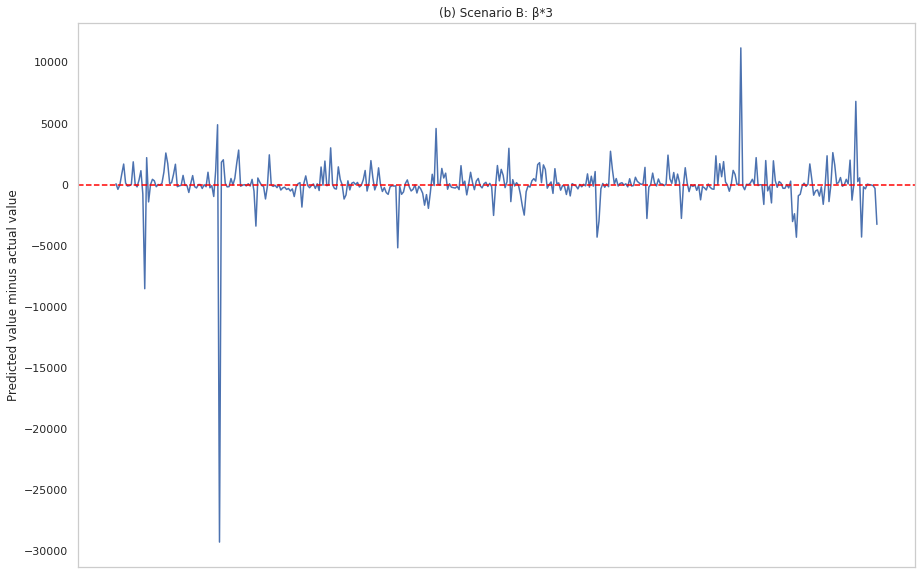

In [306]:
import matplotlib.pyplot as plt

dftriple=scena_B_result_3.copy()

dftriple = A_diff.copy()
dftriple = dftriple.sort_values('station_destination')
dftriple = dftriple.reset_index(drop=False)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(dftriple['station_destination'], dftriple['change_ratio'])

# 隐藏x轴刻度
ax.xaxis.set_visible(False)

# 设置背景为纯白色，关掉网格
ax.set_facecolor('white')
ax.grid(False)

# 添加红色虚线
ax.axhline(y=0, color='red', linestyle='--')

ax.set_ylabel('Predicted value minus actual value')
ax.set_title('(b) Scenario B: β*3')

plt.savefig('Output/Figure_scenario_Btriplebydestination.png', dpi=300, bbox_inches='tight')

plt.show()

In [274]:
scena_B_result_5 = pd.DataFrame(columns=['SIM_est_5beta_sum','flow_sum'])
scena_B_result_5['SIM_est_5beta_sum'] = pd.DataFrame(scena_B_result.groupby(["station_destination"])["SIM_est_5beta"].agg(np.sum))
scena_B_result_5['flow_sum'] = pd.DataFrame(scena_B_result.groupby(["station_destination"])["flows"].agg(np.sum))
scena_B_result_5['change_ratio'] = (scena_B_result_5['SIM_est_5beta_sum'] - scena_B_result_5['flow_sum']) 
scena_B_result_5 = scena_B_result_5.sort_values('change_ratio')
scena_B_result_5
scena_B_result_5.to_csv('Output/scena_B_result_5.csv', index=True)

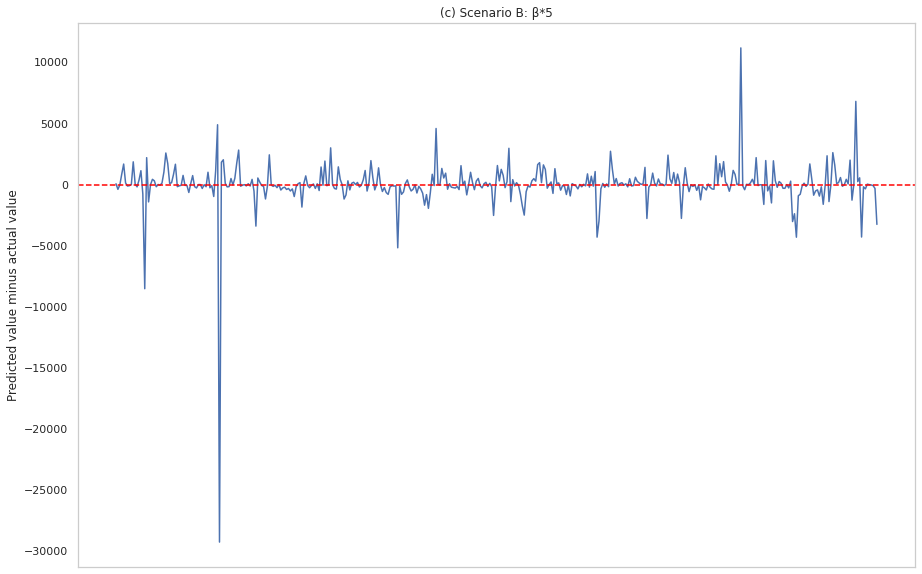

In [305]:
import matplotlib.pyplot as plt

dffive=scena_B_result_5.copy()

dffive = A_diff.copy()
dffive = dffive.sort_values('station_destination')
dffive = dffive.reset_index(drop=False)

fig, ax = plt.subplots(figsize=(15, 10))
ax.plot(dffive['station_destination'], dffive['change_ratio'])

# 隐藏x轴刻度
ax.xaxis.set_visible(False)

# 设置背景为纯白色，关掉网格
ax.set_facecolor('white')
ax.grid(False)

# 添加红色虚线
ax.axhline(y=0, color='red', linestyle='--')

ax.set_ylabel('Predicted value minus actual value')
ax.set_title('(c) Scenario B: β*5')

plt.savefig('Output/Figure_scenario_Bfivebydestination.png', dpi=300, bbox_inches='tight')

plt.show()

<Figure size 1800x1200 with 0 Axes>

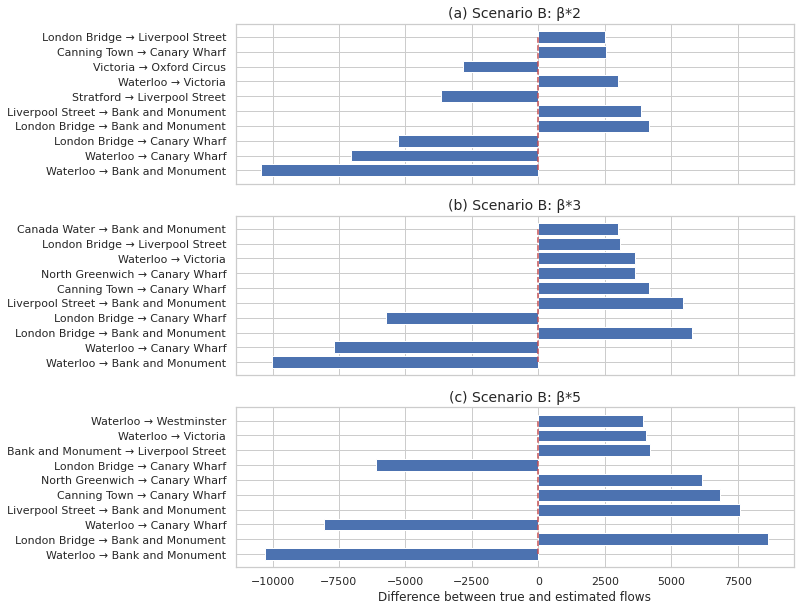

In [166]:
plt.figure(dpi=300)
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(3, 1, figsize=(10, 10), sharey=False, sharex=True)

scena_B_result['abs_2beta_diff'] = abs(scena_B_result['2beta_diff'])
scena_B_result['abs_3beta_diff'] = abs(scena_B_result['3beta_diff'])
scena_B_result['abs_5beta_diff'] = abs(scena_B_result['5beta_diff'])
o_d_2beta = []
o_d_3beta = []
o_d_5beta = []

##### plot a #####
scena_B_result = scena_B_result.sort_values('abs_2beta_diff',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
for i in range(10):
    o_d_2beta.append(scena_B_result.iloc[i,0] + ' → ' + scena_B_result.iloc[i,1])
ax[0].barh(o_d_2beta, scena_B_result.loc[:9,'2beta_diff'])
ax[0].vlines(0, 0, 9, colors = "r", linestyles = "dashed")
ax[0].set_title('(a) Scenario B: β*2',fontsize=14)

##### plot b #####
scena_B_result = scena_B_result.sort_values('abs_3beta_diff',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
for i in range(10):
    o_d_3beta.append(scena_B_result.iloc[i,0] + ' → ' + scena_B_result.iloc[i,1])
ax[1].barh(o_d_3beta, scena_B_result.loc[:9,'3beta_diff'])
ax[1].vlines(0, 0, 9, colors = "r", linestyles = "dashed")
ax[1].set_title('(b) Scenario B: β*3',fontsize=14)

##### plot c #####
scena_B_result = scena_B_result.sort_values('abs_5beta_diff',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
for i in range(10):
    o_d_5beta.append(scena_B_result.iloc[i,0] + ' → ' + scena_B_result.iloc[i,1])
ax[2].barh(o_d_5beta, scena_B_result.loc[:9,'5beta_diff'])
ax[2].vlines(0, 0, 9, colors = "r", linestyles = "dashed")
ax[2].set_title('(c) Scenario B: β*5',fontsize=14)

# 设置横坐标标签
ax[2].set_xlabel('Difference between true and estimated flows', fontsize=12)
plt.savefig('Output/Figure_scenario_B.png', dpi=300, bbox_inches='tight')

plt.show()


<Figure size 600x400 with 0 Axes>

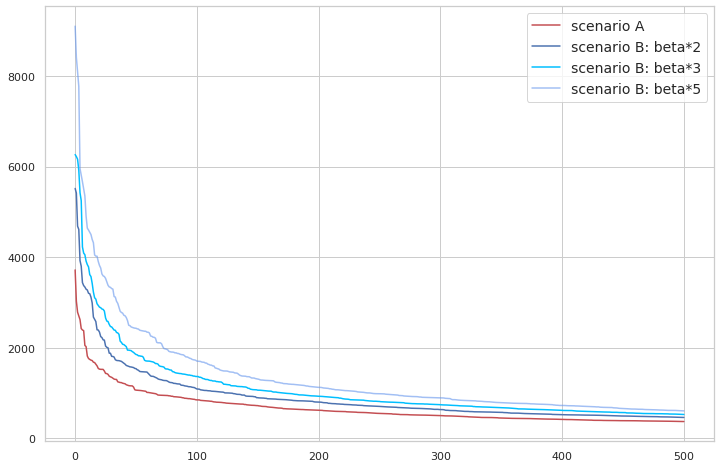

In [219]:
plt.figure(dpi=100)
fig, ax = plt.subplots(figsize=(12,8))
# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
sns.set(style="whitegrid")


A_result = A_result.sort_values('prodsimest4',ascending=False).reset_index()
A_result = A_result.drop(columns='index')
ax.plot(A_result.loc[:500,'prodsimest4'],label='scenario A',color='r')

scena_B_result = scena_B_result.sort_values('SIM_est_2beta',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
x_pt = np.arange(0,len(scena_B_result))
ax.plot(scena_B_result.loc[:500,'SIM_est_2beta'],label='scenario B: beta*2',color='b')

scena_B_result = scena_B_result.sort_values('SIM_est_3beta',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
ax.plot(scena_B_result.loc[:500,'SIM_est_3beta'],label='scenario B: beta*3',color='deepskyblue')

scena_B_result = scena_B_result.sort_values('SIM_est_5beta',ascending=False).reset_index()
scena_B_result = scena_B_result.drop(columns='index')
ax.plot(scena_B_result.loc[:500,'SIM_est_5beta'],label='scenario B: beta*5',color='cornflowerblue', alpha=0.6)


plt.legend(fontsize=14)
plt.show()

In [ ]:
GB1 = G.copy()
GB1.remove_edges_from(list(GB1.edges()))
GB1 = nx.MultiGraph(GB1)
for node in GB1.nodes():
    GB1.nodes[node]['coords'] = eval(GB1.nodes[node]['coords'])
for index,row in OD[OD['prodsimest_s2']!=0].iterrows():
    if row['station_origin'] in GB1:
        if row['station_destination'] in GB1:
            GB1.add_edge(row['station_origin'], row['station_destination'], flow=row['flows'])
edge_c = []
for node1, node2, data in GB1.edges(data=True):
    edge_c.append(float(data['flow']))
norm = [float(i)*1000/sum(edge_c) for i in edge_c]

In [ ]:
pos2 = nx.get_node_attributes(GB2 , 'coords')

fig, ax = plt.subplots(figsize = (30,35))
edg = nx.draw_networkx_edges(GB2, pos2, edge_color = edge_c2, width=norm2, edge_cmap=plt.get_cmap('viridis'), edge_vmin = 0, edge_vmax = 1000,alpha = 1)
nx.draw_networkx_nodes(GB2, pos = pos2,  node_size = 70)
plt.colorbar(edg, label = "Flow",orientation = "horizontal", shrink = 0.5 )
plt.axis("off")
plt.title("Scenario B beta=4",fontsize = 30)
plt.show()